In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [50]:
# read a CSV into a dataframe (adjust filename as needed)
events_filename = './data/event.csv'  # or provide a full path

if not os.path.exists(events_filename):
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"{events_filename!r} not found and no CSV files in the current directory.")
    filename = csv_files[0]
    print(f"No file named 'data.csv' found. Using first CSV in cwd: {filename}")

events = pd.read_csv(events_filename)
print(f"Loaded {len(events)} rows and {len(events.columns)} columns from {events_filename}")
events.head()

Loaded 107738 rows and 14 columns from ./data/event.csv


/var/folders/_b/sl_t4k5539781f29qf723b080000gn/T/ipykernel_61847/2221732598.py:11: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  events = pd.read_csv(events_filename)


,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId
0,PITCH,False,False,True,徐若熙,蔣少宏,陳晨威,B,FF,145,71.11,-91.43,[],NaN
1,PITCH,True,True,False,徐若熙,蔣少宏,陳晨威,H,FF,147,54.86,42.67,"[{'type': 'PA', 'runnerName': '陳晨威', 'isOut': ...",NaN
2,PITCH,False,True,False,徐若熙,蔣少宏,林立,F,FF,145,54.86,22.35,[],NaN
3,PITCH,False,True,False,徐若熙,蔣少宏,林立,SW,SL,135,-2.03,-56.89,[],NaN
4,PITCH,False,False,True,徐若熙,蔣少宏,林立,B,SL,139,-34.54,-144.25,[],NaN


In [51]:
events['coordX'] = events['coordX'] * 0.5 * 0.3937  # convert cm to inches and scale X
events['coordY'] = events['coordY'] * 0.5 * 0.3937  # convert cm to inches and scale Y

In [52]:
### filter out non-PITCH type
test_events = events[((events['pitcherName'] == '古林睿煬')) & (events['type'] == 'PITCH')]
# test_events = events[((events['batterName'] == '魔鷹')) & (events['type'] == 'PITCH')]

In [53]:
print(test_events.shape)
test_events.head()

(1922, 14)


,type,inPlay,isStrike,isBall,pitcherName,catcherName,batterName,pitchCode,pitchType,velocity,coordX,coordY,runners,PAId
7330,PITCH,False,True,False,古林睿煬,陳重羽,岳政華,F,FF,145,-2.710624,4.023614,[],NaN
7331,PITCH,False,False,True,古林睿煬,陳重羽,岳政華,B,FF,144,-12.122023,-10.720451,[],NaN
7332,PITCH,True,True,False,古林睿煬,陳重羽,岳政華,H,FF,142,-4.712589,-7.588567,"[{'type': 'PA', 'runnerName': '岳政華', 'isOut': ...",NaN
7333,PITCH,False,True,False,古林睿煬,陳重羽,岳東華,FOUL_BUNT,FF,138,0.027559,13.580681,[],NaN
7334,PITCH,False,False,True,古林睿煬,陳重羽,岳東華,B,FF,139,-11.222418,-20.620037,[],NaN


In [54]:
strike_zone_width = 17.0 + 2.9 # plate width + margin (one ball width on each side)
strike_zone_height = strike_zone_width * 1.2
strike_zone = [-strike_zone_width/2, strike_zone_width/2, -strike_zone_height/2, strike_zone_height/2] # left, right, bottom, top

In [55]:
# create annotated 2D heatmaps for fastballs / offspeeds / breakings showing probabilities
def _plot_pitch_heatmap(x, y, ax, title, bins=30, range_x=(-40,40), range_y=(-45,45), annotate_frac=0.03):
    if len(x) == 0 or len(y) == 0:
        ax.text(0.5, 0.5, "no data", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)
        return None

    # 2D histogram (counts)
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[range_x, range_y])
    H = H.T  # transpose so that rows correspond to y

    total = H.sum()
    if total > 0:
        H = H / total  # convert to probabilities (fraction of pitches)

    im = ax.imshow(H, extent=(range_x[0], range_x[1], range_y[0], range_y[1]),
                   origin='lower', aspect='auto', cmap='Reds', vmin=0)
    ax.set_title(title)
    ax.set_xlabel('Horizontal Location (inch)')
    ax.set_ylabel('Vertical Location (inch)')
    ax.set_xlim(range_x)
    ax.set_ylim(range_y)

    # strike zone rectangle
    ax.add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                               linewidth=2, edgecolor='white', facecolor='none', linestyle='-'))

    # annotate cells with probabilities above threshold to avoid clutter
    maxv = H.max() if H.size else 0.0
    if maxv > 0:
        thresh = max(maxv * annotate_frac, 1e-4)
        xcenters = (xedges[:-1] + xedges[1:]) / 2
        ycenters = (yedges[:-1] + yedges[1:]) / 2
        for j, yc in enumerate(ycenters):
            for i, xc in enumerate(xcenters):
                val = H[j, i]
                if val >= thresh:
                    # show percentage with one decimal
                    ax.text(xc, yc, f"{val*100:.0f}%", color='white', ha='center', va='center', fontsize=7)

    return im

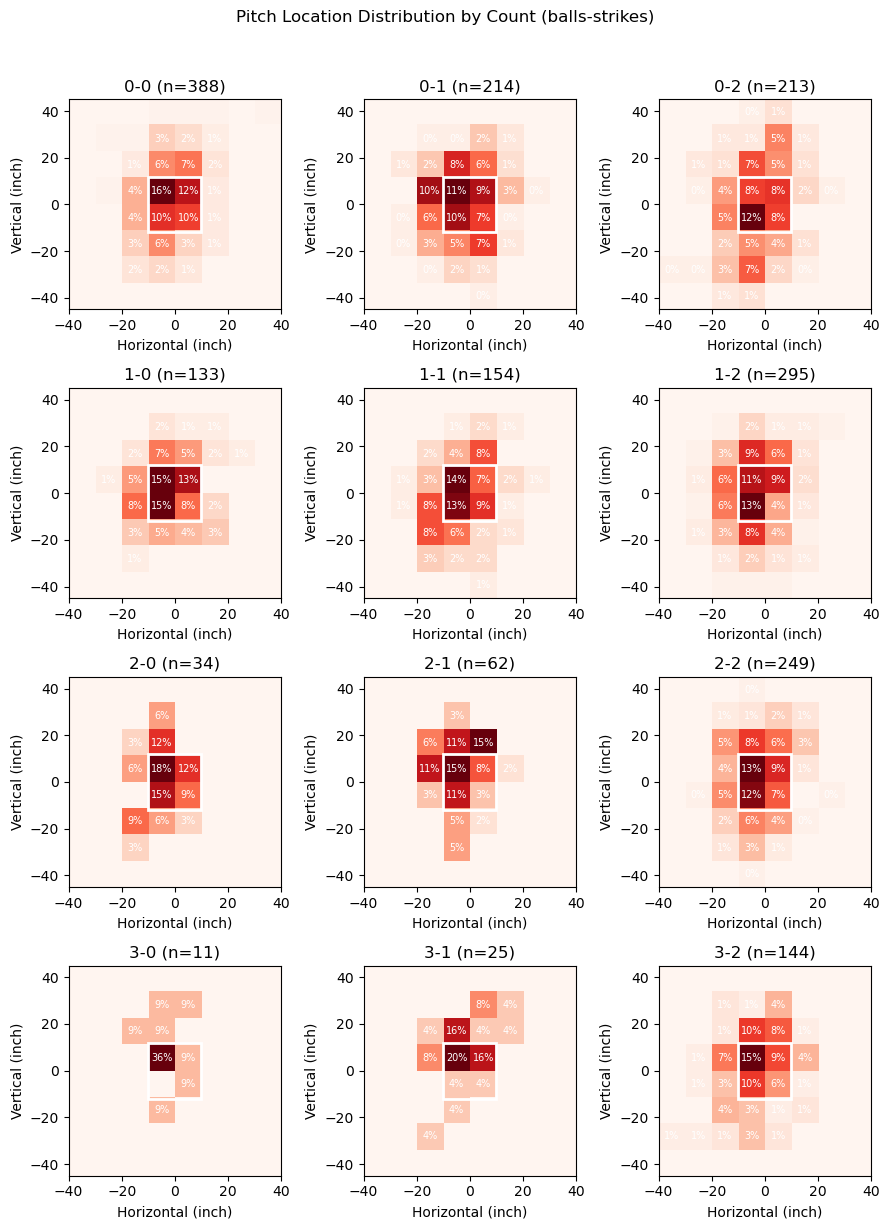

In [56]:
# reconstruct pitch counts (balls-strikes) per pitch and plot 12 heatmaps for counts 0-0 .. 3-2
# uses existing variables: events, test_events, _plot_pitch_heatmap, strike_zone_width/height, strike_zone

def assign_counts_to_pitches(df):
    # iterate rows in order and track balls/strikes for the current plate appearance
    balls = 0
    strikes = 0
    records = []
    for idx, row in df.sort_index().iterrows():
        if row.get('type') != 'PITCH':
            # ignore non-pitch rows for assignment, but if they indicate PA boundary we could reset;
            # we keep simple behavior (resets will happen on inPlay/PA markers below)
            continue

        # record count before this pitch
        records.append((idx, balls, strikes))

        # update counts based on pitch outcome flags (simple, robust heuristics)
        is_ball = bool(row.get('isBall', False))
        is_strike = bool(row.get('isStrike', False))
        in_play = bool(row.get('inPlay', False))

        # ball increments balls
        if is_ball and not is_strike:
            balls += 1
        # strike increments strikes (but fouls shouldn't push above 2)
        elif is_strike and not is_ball:
            # only increment on non-inplay strikes; fouls often set isStrike True but rules cap at 2
            if not in_play and strikes < 2:
                strikes += 1

        # if the pitch resulted in the ball being put in play or runners indicate a PA event, end the plate appearance
        runners = row.get('runners', [])
        pa_marker = False
        if isinstance(runners, list):
            for r in runners:
                if isinstance(r, dict) and r.get('type') == 'PA':
                    pa_marker = True
                    break

        if in_play or pa_marker or balls >= 4 or strikes >= 3:
            balls = 0
            strikes = 0

    # build a small DataFrame keyed by original index
    counts_df = pd.DataFrame(records, columns=['index', 'balls', 'strikes']).set_index('index')
    return counts_df

# assign counts to all pitch rows
counts_df = assign_counts_to_pitches(events)

# merge counts into the pitches DataFrame we want to plot (test_events is already filtered to the pitcher/type)
# ensure indices align (counts_df contains only indices for PITCH rows)
pe = test_events.copy()
pe = pe.join(counts_df, how='left')  # balls/strikes will be NaN if reconstruction failed for some rows

# fill missing with 0-0 to avoid issues (or drop NaNs if preferred)
pe['balls'] = pe['balls'].fillna(0).astype(int)
pe['strikes'] = pe['strikes'].fillna(0).astype(int)

# prepare plotting grid: 4 rows (balls 0..3) x 3 cols (strikes 0..2)
n_balls = 4
n_strikes = 3
fig, axes = plt.subplots(n_balls, n_strikes, figsize=(3*n_strikes, 3*n_balls), tight_layout=True)

# loop and plot each count
for b in range(n_balls):
    for s in range(n_strikes):
        ax = axes[b, s] if (n_balls > 1 and n_strikes > 1) else axes[max(b, s)]
        subset = pe[(pe['balls'] == b) & (pe['strikes'] == s)]
        x = subset['coordX'].to_numpy()
        y = subset['coordY'].to_numpy()
        title = f"{b}-{s} (n={len(subset)})"
        _plot_pitch_heatmap(x, y, ax, title, bins=8, range_x=(-40,40), range_y=(-45,45), annotate_frac=0.03)

# label outer axes nicely
for ax in axes.flatten():
    ax.set_xlabel('Horizontal (inch)')
    ax.set_ylabel('Vertical (inch)')

fig.suptitle("Pitch Location Distribution by Count (balls-strikes)", y=1.02)
plt.show()

In [57]:
_fastball_tokens = {'FF', 'SI', 'FC'} # four-seam, sinker, cutter
_offspeed_tokens = {'CH', 'FO', 'FS', 'KN', 'EP'} # changeup, forkball, split-finger, knuckleball
_breaking_tokens = {'CU', 'SL'} # curveball, slider
fastballs = test_events[test_events['pitchType'].isin(_fastball_tokens)]
offspeeds = test_events[test_events['pitchType'].isin(_offspeed_tokens)]
breakings = test_events[test_events['pitchType'].isin(_breaking_tokens)]

Text(0.5, 1.0, 'Pitch Velocity Distribution')

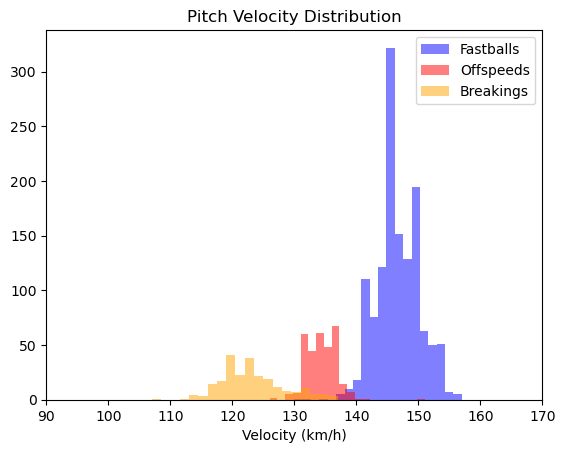

In [58]:
plt.hist(fastballs['velocity'].to_numpy(dtype=float), bins=20, alpha=0.5, label='Fastballs', color='blue')
plt.hist(offspeeds['velocity'].to_numpy(dtype=float), bins=20, alpha=0.5, label='Offspeeds', color='red')
plt.hist(breakings['velocity'].to_numpy(dtype=float), bins=20, alpha=0.5, label='Breakings', color='orange')
plt.xlabel('Velocity (km/h)')
plt.xlim(90, 170)
plt.legend()
plt.title('Pitch Velocity Distribution')



In [59]:
fastballs_X = fastballs['coordX'].to_numpy()
fastballs_Y = fastballs['coordY'].to_numpy()
offspeeds_X = offspeeds['coordX'].to_numpy()
offspeeds_Y = offspeeds['coordY'].to_numpy()
breakings_X = breakings['coordX'].to_numpy()
breakings_Y = breakings['coordY'].to_numpy()

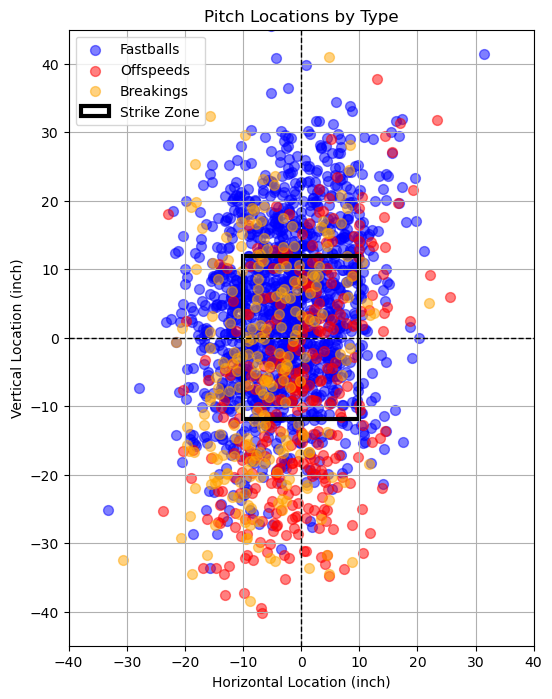

In [60]:
plt.figure(figsize=(6,8))
plt.scatter(fastballs_X, fastballs_Y, color='blue', label='Fastballs', alpha=0.5, s=50)
plt.scatter(offspeeds_X, offspeeds_Y, color='red', label='Offspeeds', alpha=0.5, s=50)
plt.scatter(breakings_X, breakings_Y, color='orange', label='Breakings', alpha=0.5, s=50)
plt.xlim(-40, 40)
plt.ylim(-45, 45)
plt.xlabel('Horizontal Location (inch)')
plt.ylabel('Vertical Location (inch)')
plt.title('Pitch Locations by Type')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.gca().add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                                  linewidth=3, edgecolor='k', facecolor='none', linestyle='-', label='Strike Zone'))
plt.legend()
plt.grid()
plt.show()

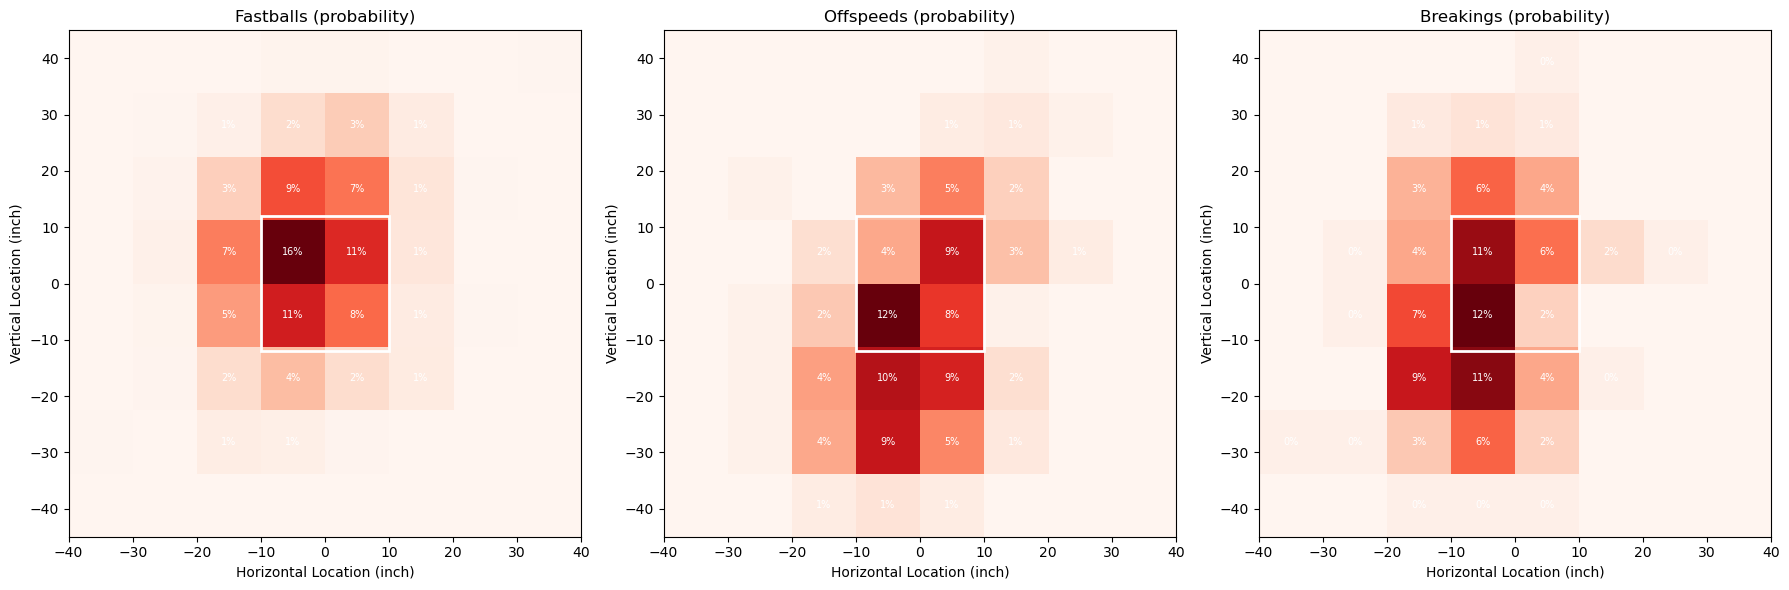

In [61]:


fig, axes = plt.subplots(1, 3, figsize=(18, 6), tight_layout=True)

ims = []
ims.append(_plot_pitch_heatmap(fastballs_X, fastballs_Y, axes[0], 'Fastballs (probability)', bins=8))
ims.append(_plot_pitch_heatmap(offspeeds_X, offspeeds_Y, axes[1], 'Offspeeds (probability)', bins=8))
ims.append(_plot_pitch_heatmap(breakings_X, breakings_Y, axes[2], 'Breakings (probability)', bins=8))

# set common color scale and add a single colorbar for all subplots
# valid_ims = [im for im in ims if im is not None]
# if valid_ims:
#     global_max = max(im.get_array().max() for im in valid_ims)
#     # ensure all images share same clim
#     for im in valid_ims:
#         im.set_clim(0, global_max)
#     cbar = fig.colorbar(valid_ims[0], ax=axes.ravel().tolist(), shrink=0.8)
#     cbar.set_label('Probability per bin (fraction)')
plt.show()

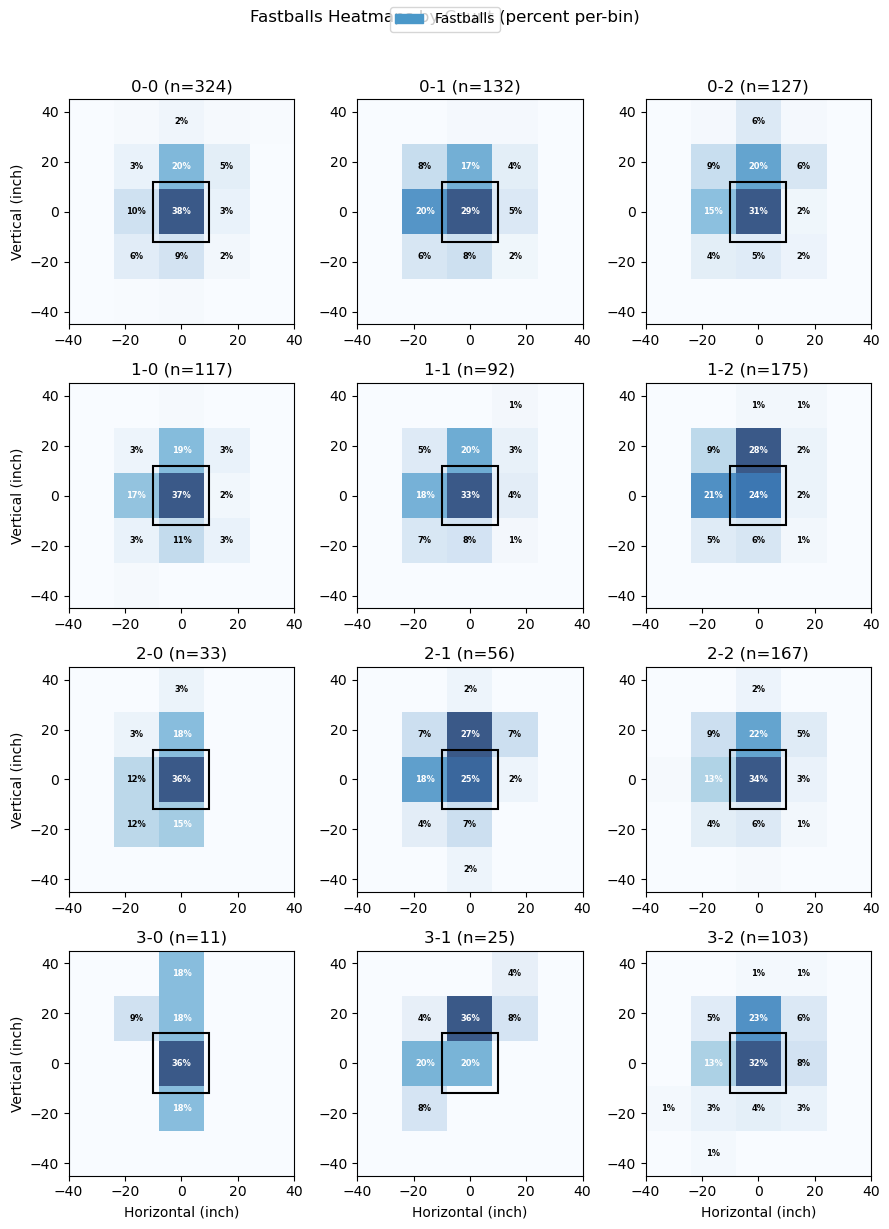

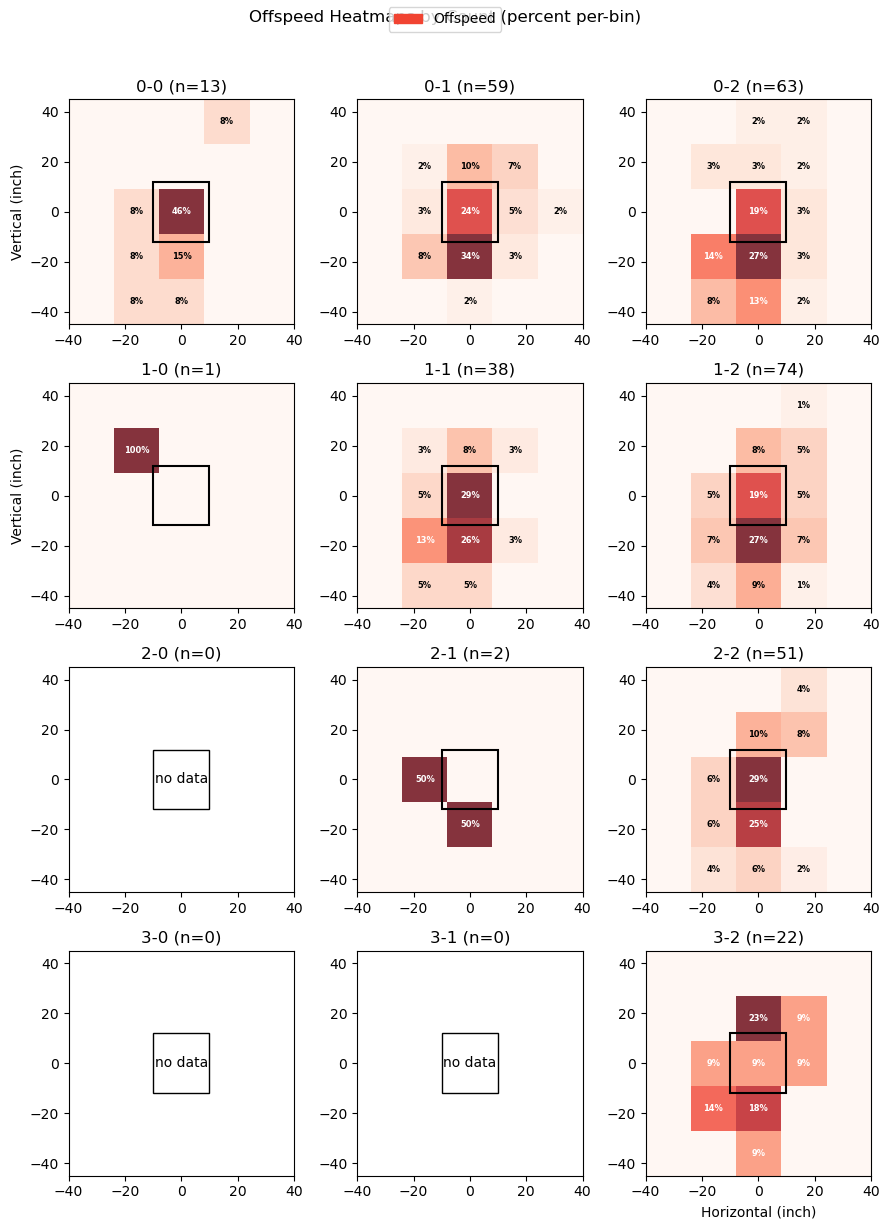

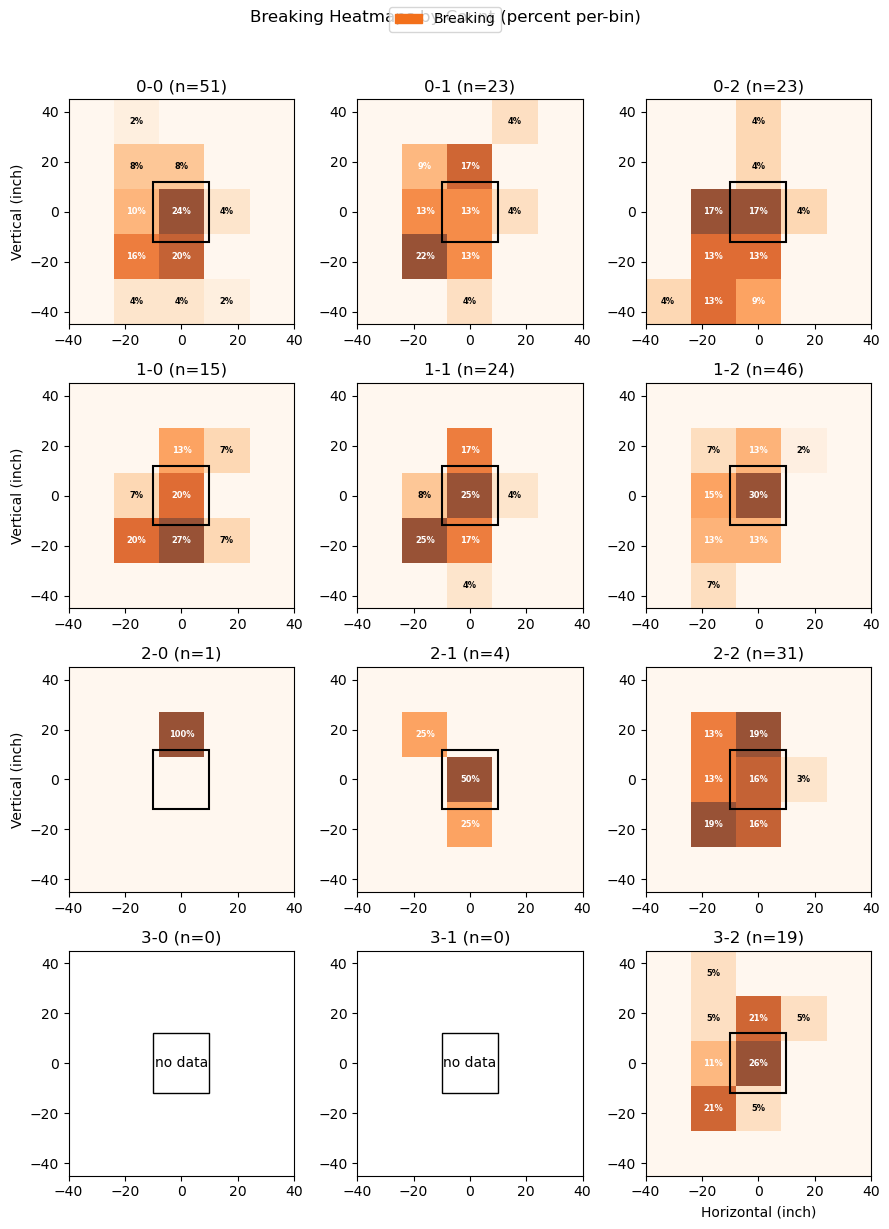

In [62]:
# create three separate figures: one per pitch-type (fast / off / break)
n_balls = 4
n_strikes = 3
bins = 5
range_x = (-40, 40)
range_y = (-45, 45)

type_specs = [
    ('fast', _fastball_tokens, 'Blues', 'Fastballs'),
    ('off',  _offspeed_tokens, 'Reds',  'Offspeed'),
    ('break',_breaking_tokens,'Oranges','Breaking')
]

for tkey, tokens, cmap, suptitle in type_specs:
    fig, axes = plt.subplots(n_balls, n_strikes, figsize=(3*n_strikes, 3*n_balls), tight_layout=True)
    for b in range(n_balls):
        for s in range(n_strikes):
            ax = axes[b, s]
            subset = pe[(pe['balls'] == b) & (pe['strikes'] == s) & (pe['pitchType'].isin(tokens))]

            # 2D histogram (fraction within this count, for this pitch-type)
            if len(subset):
                H, xedges, yedges = np.histogram2d(subset['coordX'], subset['coordY'], bins=bins, range=[range_x, range_y])
                H = H.T
                total = H.sum()
                if total > 0:
                    H = H / total
            else:
                H = np.zeros((bins, bins))
                xedges = np.linspace(range_x[0], range_x[1], bins+1)
                yedges = np.linspace(range_y[0], range_y[1], bins+1)

            # no data for this count & type
            if H.sum() == 0:
                ax.text(0.5, 0.5, "no data", ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{b}-{s} (n=0)")
                ax.set_xlim(range_x); ax.set_ylim(range_y)
                ax.add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                                           linewidth=1.0, edgecolor='k', facecolor='none'))
                continue

            # plotting
            vmin = 0.0
            vmax = max(H.max(), 1e-6)
            ax.imshow(H, extent=(range_x[0], range_x[1], range_y[0], range_y[1]),
                      origin='lower', aspect='auto', cmap=cmap, alpha=0.8, vmin=vmin, vmax=vmax)

            # annotate per-bin percentages above threshold
            annotate_frac = 0.03
            thresh = max(vmax * annotate_frac, 1e-4)
            xcenters = (xedges[:-1] + xedges[1:]) / 2
            ycenters = (yedges[:-1] + yedges[1:]) / 2
            for j, yc in enumerate(ycenters):
                for i, xc in enumerate(xcenters):
                    val = H[j, i]
                    if val >= thresh:
                        text_color = 'white' if val > vmax*0.35 else 'k'
                        ax.text(xc, yc, f"{val*100:.0f}%", color=text_color, ha='center', va='center', fontsize=6, weight='bold')

            # strike zone rect, titles and limits
            ax.add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                                       linewidth=1.5, edgecolor='k', facecolor='none'))
            ax.set_title(f"{b}-{s} (n={len(subset)})")
            ax.set_xlim(range_x); ax.set_ylim(range_y)
            if b == n_balls - 1:
                ax.set_xlabel('Horizontal (inch)')
            if s == 0:
                ax.set_ylabel('Vertical (inch)')

    fig.suptitle(f"{suptitle} Heatmaps by Count (percent per-bin)", y=1.02)
    # single legend-like patch for color
    import matplotlib.patches as mpatches
    patch = mpatches.Patch(color=plt.get_cmap(cmap)(0.6), label=suptitle)
    fig.legend(handles=[patch], loc='upper center')
    plt.show()
